In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
# jupyter notebook の出力を省略させたくない場合のオプション設定
np.set_printoptions(threshold=100)

In [3]:
def import_outside_air_temperature_d_t(area_number) -> np.ndarray:
    """
    外気温度を外部CSVファイルからND配列に読み込む
    Returns:
        outside_air_temperature_d_t : 外気温度[8760], ℃ 
    """
    df = pd.read_csv('climateData_' + str(area_number) + '.csv', encoding='SHIFT_JIS')
    ds = df['外気温[℃]']
    outside_air_temperature_d_t = ds.values
    return outside_air_temperature_d_t

In [4]:
# 日平均外気温度の読込テスト
import_outside_air_temperature_d_t(5)

array([-0.9, -2. , -2.8, ..., -0.4, -0.1, -0.5])

In [5]:
def import_heating_season_d(area_number) -> np.ndarray:
    """
    暖冷房期間を外部CSVファイルからND配列に読み込む
    Returns:
         HeatingSeason_d: 暖房期間の判定[365], True/False
    """
    df = pd.read_csv('air_conditioning_season_sample.csv', encoding='SHIFT_JIS')
    ds = df[str(area_number) + '地域']
    HeatingSeason_d = ds.values
    return HeatingSeason_d

In [6]:
# 暖冷房期間の読込テスト
import_heating_season_d(5)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

# (自立)換気設備
自立循環型住宅の試算では、換気設備は省エネ基準の計算過程において時刻別比消費電力を置き換えることで評価する。

### 時刻別比消費電力
$$
f_{ SFP, d, t }
=
\begin{cases}
f_{ SFP }
& ,
\mbox{制御しない}
\\
f_{ SFP, single, d, t }
& ,
\mbox{片側運転}
\\
f_{ SFP, by-pass, d, t }
& ,
\mbox{バイパス運転}
\\
f_{ SFP, hybrid-temperature, d, t }
& ,
\mbox{温度差利用型ハイブリッド運転}
\end{cases}
$$

$ f_{ SFP, d, t } $：日付dの時刻tにおける比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, single, d, t } $：日付dの時刻tにおける片側運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, by-pass, d, t } $：日付dの時刻tにおけるバイパス運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP, hybrid-temperature, d, t } $：日付dの時刻tにおける温度差利用型ハイブリット運転機能を有する換気設備のの比消費電力,W/(m<sup>3</sup>/h)   

In [7]:
def get_SFP_d_t(ventilation_control_mode, \
                f_SFP, \
                f_SFP_bypass, \
                HeatingSeason_d, \
                outside_air_temperature_d_t, \
                area_number, \
                total_floor_area, \
                val_min, \
                val_max, \
                maximum_iterations, \
                house_story_number, \
                room_air_temperature, \
                c_value, \
                ventilation_type, \
                use_chimney, \
                alphaA_vnt_sum):
    
    """時刻別消費電力量を計算する
    
    Parameters
    ----------
    ventilation_cntrol_mode : strings
        換気設備の制御方式（制御しない、片側運転、バイパス運転、温度差利用型ハイブリッド運転）,--  
        
    f_SFP : float
        比消費電力,W/(m^3/h)  

    f_SFP_bypass : float
        バイパス運転時の比消費電力,W/(m^3/h)  
        
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, --
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
        
    outside_air_temperature_d_t : ndarray(N-dimensional array)
        1年間の時刻別の外気温度を格納したND配列, ℃
          
    area_number : int
        地域区分番号,--  
    
    total_floor_area : float
        延べ床面積,m^2
        
    val_min : float
        二分法における初項（最小値）,Pa  （仕様書には書かない） 
    
    val_max : float
        二分法における初項（最大値）,Pa  （仕様書には書かない）
    
    tolerance : float
        二分法における許容誤差,Pa  （仕様書には書く）

    maximum_iterations : float
        二分法における繰り返し計算の上限回数,回  
        
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float  （仕様書には書かない）
        室温,℃  
    
    c_value : float  （仕様書には書く）
        パッシブ換気量推定のためのC値,cm^2/m^2  （※他に影響をあたえないために、詳細に書く）
        おおよその値はコラムかコメントで情報提供する。
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,- 
    
    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_vnt_sum : float
        給排気端末の有効開口面積の合計値,m^2  
    
    Returns
    ----------
    SFP_d_t : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列,W/(m^3/h)  
        d日t時の比消費電力量が年開始時から8760個連続して格納されている
    """
    
    if ventilation_control_mode == "制御しない":
        SFP_d_t = np.ones(8760) * f_SFP
        
    elif ventilation_control_mode == "片側運転":
        SFP_d_t = get_SFP_single_d_t(f_SFP, HeatingSeason_d)
    
    elif ventilation_control_mode == "バイパス運転":
        SFP_d_t = get_SFP_bypass_d_t(f_SFP, f_SFP_bypass, HeatingSeason_d)
    
    elif ventilation_control_mode == "温度差利用型ハイブリッド運転":
        
        #　現時点では給排気口の面積は1:1とするため、給気口面積は全体の半分とする。
        alphaA_SA = alphaA_vnt_sum / 2
        alphaA_EA = alphaA_vnt_sum - alphaA_SA
        
        # 現時点では平屋は評価対象外、3階建て以上は未実装のためhouse_story_number は「2」の固定値となる。
        SFP_d_t = get_SFP_hybrid_temperature_d_t( \
                                                 f_SFP, \
                                                 HeatingSeason_d, \
                                                 outside_air_temperature_d_t, \
                                                 total_floor_area, \
                                                 val_min, \
                                                 val_max, \
                                                 maximum_iterations, \
                                                 house_story_number, \
                                                 room_air_temperature, \
                                                 c_value, \
                                                 ventilation_type, \
                                                 use_chimney, \
                                                 alphaA_SA, \
                                                 alphaA_EA \
                                                )
    
    else:
        raise Exception
    
    return SFP_d_t

## 片側運転機能を有する換気設備の比消費電力

### 時刻別比消費電力
$$
f_{ SFP, single, d, t }
=
f_{ SFP }
\times
C_{ single, d, t }
$$

$$
C_{ single, d, t }
=
\begin{cases}
0.58
& ,
HeatingSeason_{ d } = \mbox{False}
\\
1
& ,
HeatingSeason_{ d } = \mbox{True}
\end{cases}
$$

$ f_{ SFP, single, d, t } $：日付dの時刻tにおける片側運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：換気設備の比消費電力,W/(m<sup>3</sup>/h)    
$ C_{ single, d, t } $：日付dの時刻tにおける片側運転の比消費電力の補正係数,-  
$ HeatingSeason_{ d } $：日付dが暖房期である,True/False   

In [8]:
def get_SFP_single_d_t(f_SFP, HeatingSeason_d):
    """片側運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    f_SFP : float
        比消費電力,W/(m^3/h)  
        
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    Returns
    ----------
    SFP_single_d_t : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
    
    C_d_t = np.where(np.repeat(HeatingSeason_d, 24) == True, 1, 0.58)
    
    SFP_single_d_t = f_SFP * C_d_t
    
    return SFP_single_d_t

In [9]:
# 片側運転の動作テスト
get_SFP_single_d_t(0.3, np.tile([True, False, True, False, True], 73))

array([ 0.3,  0.3,  0.3, ...,  0.3,  0.3,  0.3])

## バイパス運転を有する換気設備の比消費電力

### 時刻別比消費電力
$$
f_{ SFP, by-pass, d, t }
=
\begin{cases}
f_{ SFP }
& ,
HeatingSeason_{ d } = \mbox{True}
\\
f_{ SFP, by-pass }
& ,
HeatingSeason_{ d } = \mbox{False}
\end{cases}
$$

$ f_{ SFP, by-pass, d, t } $：日付dの時刻tにおけるバイパス運転機能を有する換気設備の比消費電力,W/(m<sup>3</sup>/h)  
$ f_{ SFP } $：換気設備の比消費電力,W/(m<sup>3</sup>/h)    
$ f_{ SFP, by-pass } $：換気設備のバイパス運転時の比消費電力,W/(m<sup>3</sup>/h)    

In [10]:
def get_SFP_bypass_d_t(f_SFP, f_SFP_bypass, HeatingSeason_d):
    """バイパス運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    f_SFP : float
        比消費電力,W/(m^3/h)  
    
    f_SFP_bypass : float
        バイパス運転時の比消費電力,W/(m^3/h)  
        
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    Returns
    ----------
    SFP_bypass_d_t : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
    
    SFP_bypass_d_t = np.where(np.repeat(HeatingSeason_d, 24) == True, f_SFP, f_SFP_bypass)
    
    return SFP_bypass_d_t

In [11]:
# バイパス運転の動作テスト
get_SFP_bypass_d_t(0.3, 0.5, np.tile([True, False, True, False, True], 73))

array([ 0.3,  0.3,  0.3, ...,  0.3,  0.3,  0.3])

## 温度差利用型ハイブリッド運転を有する換気設備の比消費電力

### 時刻別比消費電力
$$
f_{ SFP, hybrid-temperature, d, t }
=
\begin{cases}
0
& ,
EnableHybrid_{ d, t } = \mbox{True}
\\
f_{ SFP }
& ,
EnableHybrid_{ d } = \mbox{False}
\end{cases}
$$

$ EnableHybrid_{ d, t } $：日付dの時刻tにおける温度差利用型ハイブリッド運転が有効であるか否かの判定,True/False

In [12]:
def get_SFP_hybrid_temperature_d_t(f_SFP, \
                                   HeatingSeason_d, \
                                   outside_air_temperature_d_t, \
                                   total_floor_area, \
                                   val_min, \
                                   val_max, \
                                   maximum_iterations, \
                                   house_story_number, \
                                   room_air_temperature, \
                                   c_value, \
                                   ventilation_type, \
                                   use_chimney, \
                                   alphaA_SA, \
                                   alphaA_EA):
    
    """温度差利用ハイブリッド運転機能有する換気設備の時刻別比消費電量を計算する
    
    Parameters
    ----------
    f_SFP : float
        比消費電力,W/(m^3/h)  
    
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    area_number : int
        地域区分番号,--  
    
    total_floor_area : float
        延べ床面積,m^2
        
    val_min : float
        二分法における初項（最小値）,Pa  
    
    val_max : float
        二分法における初項（最大値）,Pa  

    maximum_iterations : float
        二分法における繰り返し計算の上限回数,回  
        
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float
        室温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-  
    
    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2          
    
    
    Returns
    ----------
    SFP_hybrid_temperature_d_t : ndarray(N-dimensional array)
        1年間の全時間の比消費電力量を格納したND配列, kWh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
        
    outside_air_temperature_d_t = import_outside_air_temperature_d_t(area_number)
    
    enable_hybrid_d_t = get_enable_hybrid_d_t( \
                                              total_floor_area, \
                                              outside_air_temperature_d_t, \
                                              HeatingSeason_d, \
                                              val_min, \
                                              val_max, \
                                              maximum_iterations, \
                                              house_story_number, \
                                              room_air_temperature, \
                                              c_value, \
                                              ventilation_type, \
                                              use_chimney, \
                                              alphaA_SA, \
                                              alphaA_EA \
                                             )
    
    SFP_hybrid_temperature_d_t = np.where(enable_hybrid_d_t == True, 0, f_SFP)
    
    return SFP_hybrid_temperature_d_t

In [13]:
def get_enable_hybrid_d_t(total_floor_area, \
                          outside_air_temperature_d_t, \
                          HeatingSeason_d, \
                          val_min, \
                          val_max, \
                          maximum_iterations, \
                          house_story_number, \
                          room_air_temperature, \
                          c_value, \
                          ventilation_type, \
                          use_chimney, \
                          alphaA_SA, \
                          alphaA_EA):
    
    """温度差利用ハイブリッド運転が有効になる時刻を判定する。
    
    Parameters
    ----------
    total_floor_area : float
        延べ床面積,m^2  
    
    outside_air_temerature_d_t : ndarray(N-dimensional array)
        1年間の全時間の外気温度を格納したND配列, ℃
        d日t時の可否判定が年開始時から8760個連続して格納されている
        
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
        
    val_min : float
        二分法における初項（最小値）,Pa  
    
    val_max : float
        二分法における初項（最大値）,Pa  

    maximum_iterations : float
        二分法における繰り返し計算の上限回数,回  
        
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float
        室温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-  

    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2  
        
        
    Returns
    ----------
    enable_hybrid_d_t : ndarray(N-dimensional array)
        1年間の全時間の温度差利用型ハイブリッド運転の可否判定を格納したND配列, True/False
        d日t時の可否判定が年開始時から8760個連続して格納されている
    """
    ventilation_volume = total_floor_area * 2.4 * 0.5
    
    natural_ventilation_volume_d_t = \
        get_natural_ventilation_volume_d_t( \
                                           outside_air_temperature_d_t, \
                                           HeatingSeason_d, \
                                           val_min, \
                                           val_max, \
                                           maximum_iterations, \
                                           house_story_number, \
                                           room_air_temperature, \
                                           c_value, \
                                           total_floor_area, \
                                           ventilation_type, \
                                           use_chimney, \
                                           alphaA_SA, \
                                           alphaA_EA \
                                          )
    
    enable_hybrid_d_t = np.where(natural_ventilation_volume_d_t >= ventilation_volume, True, False)
    
    return enable_hybrid_d_t

In [14]:
def get_natural_ventilation_volume_d_t(outside_air_temperature_d_t, \
                                       HeatingSeason_d,  \
                                       val_min, \
                                       val_max, \
                                       maximum_iterations, \
                                       house_story_number, \
                                       room_air_temperature, \
                                       c_value, \
                                       total_floor_area, \
                                       ventilation_type, \
                                       use_chimney, \
                                       alphaA_SA, \
                                       alphaA_EA):
    
    """温度差利用時の時刻別自然換気量を計算する。
    
    Parameters
    ----------
    outside_air_temerature_d_t : ndarray(N-dimensional array)
        1年間の全時間の外気温度を格納したND配列, ℃
        d日t時の可否判定が年開始時から8760個連続して格納されている
        
    HeatingSeason_d : ndarray(N-dimensional array)
        1年間の日別の暖房期間の判断を格納したND配列, h
        d日が暖房期間の場合True、それ以外の場合はFalseが格納されている。
    
    val_min : float
        二分法における初項（最小値）,Pa  
    
    val_max : float
        二分法における初項（最大値）,Pa  

    maximum_iterations : float
        二分法における繰り返し計算の上限回数,回  
        
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float
        室温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-  

    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2  
        
    Returns
    ----------
    natural_ventilation_volume_d_t : ndarray(N-dimensional array)
        1年間の自然換気量を格納したND列, m^3/h
        d日t時の自然換気量が年開始時から8760個連続して格納されている
    """
    
    heating_season_d_t = np.repeat(HeatingSeason_d, 24)
    
    natural_ventilation_volume_d_t = np.zeros(8760)
    
    for t in range(8760):
        
        if heating_season_d_t[t] == True:
            natural_ventilation_volume_d_t[t] = \
                get_natural_ventilation_volume_by_scipy( \
                                                        val_min, \
                                                        val_max, \
                                                        maximum_iterations, \
                                                        house_story_number, \
                                                        room_air_temperature, \
                                                        outside_air_temperature_d_t[t], \
                                                        c_value, \
                                                        total_floor_area, \
                                                        ventilation_type, \
                                                        use_chimney, \
                                                        alphaA_SA, \
                                                        alphaA_EA)
                                                
    return natural_ventilation_volume_d_t

In [15]:
def get_natural_ventilation_volume_by_scipy(val_min, \
                                            val_max, \
                                            maximum_iterations, \
                                            house_story_number, \
                                            room_air_temperature, \
                                            outside_air_temperature, \
                                            c_value, \
                                            total_floor_area, \
                                            ventilation_type, \
                                            use_chimney, \
                                            alphaA_SA, \
                                            alphaA_EA):
    
    """温度差利用時の自然換気量をscipyを利用して収束計算（二分法）で求める。
    
    Parameters
    ----------
    val_min : float
        二分法における初項（最小値）,Pa  
    
    val_max : float
        二分法における初項（最大値）,Pa  

    maximum_iterations : float
        二分法における繰り返し計算の上限回数,回  
        
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-

    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2  
    
    
    Returns
    ----------
    natural_ventilation_volume : float
        室内外温度差による自然換気量,m^3/h  
    """
    
    # 高階関数による引数と戻り値の単純化
    def f_high_order(): 
    
        def f_ho(pressure_difference):
            
            Q_bal, Q_in, Q_out, Q_leak = f(pressure_difference, \
                                           house_story_number, \
                                           room_air_temperature, \
                                           outside_air_temperature, \
                                           c_value, \
                                           total_floor_area, \
                                           ventilation_type, \
                                           use_chimney, \
                                           alphaA_SA, \
                                           alphaA_EA \
                                          )
            return Q_bal
        
        return f_ho
    
    f_ho = f_high_order()
    
    
    from scipy import optimize
    
    # scipy.optimize.bisect の引数 xtol, rtol の調査報告
    # xtol, rtol は numpy.allclose 用の引き数。収束判定を　numpy.allclose で行いたいときに使用するのではないか？
    # https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
    
    root = optimize.bisect(f_ho, val_min, val_max, xtol=2e-12, rtol=8.881784197001252e-16, maxiter=maximum_iterations, full_output=True, disp=True)
    
    pressure_difference = root[0]
    
    # 求めた解でQ_bal以外の解を得る
    Qs = f(\
           pressure_difference, \
           house_story_number, \
           room_air_temperature, \
           outside_air_temperature, \
           c_value, \
           total_floor_area, \
           ventilation_type, \
           use_chimney, \
           alphaA_SA, \
           alphaA_EA \
          )
    
    Q_leak = Qs[3]
    
    natural_ventilation_volume = Q_leak
    
    # 仕様書における許容誤差の判定 「10^-2 m^3/hの範囲内」
    if Qs[0] * 100 > 1:
        raise Exception
        
    
    # 動作確認用のreturn
    # return natural_ventilation_volume, root[1], root, Qs
    
    return natural_ventilation_volume

In [16]:
def f(pressure_difference, \
      house_story_number, \
      room_air_temperature, \
      outside_air_temperature, \
      c_value, \
      total_floor_area, \
      ventilation_type, \
      use_chimney, \
      alphaA_SA, \
      alphaA_EA):
    
    """温度差利用時の自然換気量(=隙間風量)を求める(すきま風計算マクロ.xlsm 準拠)。
    
    Parameters
    ----------
    pressure_difference : float
        差圧,Pa      
    
    house_story_number : int
        建物階数（1:平屋,2:2階建て,3:3階建て以上）,階  
    
    room_air_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-  
    
    use_chimney : boolean
        煙突換気を使用する,true/false 
        
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2  
    
    Returns
    ----------
    Q_bal : float
        隙間風合計値,m^3/h  
    
    Q_in : float
        隙間風流入量,m^3/h  
    
    Q_out : float
        隙間風流出量,m^3/h  

    Q_leak : float
        隙間風量,m^3/h  
    
    """
    
    Q_bal = 0
    Q_in = 0
    Q_out = 0
    Q_leak = 0
    
    # 平屋は現時点では評価対象外。空の関数のみ用意している状態。
    if house_story_number ==1:
        Q_bal, Q_in, Q_out, Q_leak = f_1story( \
                                              pressure_difference, \
                                              room_air_temperature, \
                                              outside_air_temperature, \
                                              c_value, \
                                              total_floor_area, \
                                              ventilation_type, \
                                              use_chimney, \
                                              alphaA_SA, \
                                              alphaA_EA \
                                             )

    if house_story_number == 2:
        Q_bal, Q_in, Q_out, Q_leak = f_2story( \
                                              pressure_difference, \
                                              room_air_temperature, \
                                              outside_air_temperature, \
                                              c_value, \
                                              total_floor_area, \
                                              ventilation_type, \
                                              use_chimney, \
                                              alphaA_SA, \
                                              alphaA_EA \
                                             )
    
    # 3階は現時点では未実装。空の関数のみ用意している状態。
    if house_story_number == 3:
        Q_bal, Q_in, Q_out, Q_leak = f_3story( \
                                              pressure_difference, \
                                              room_air_temperature, \
                                              outside_air_temperature, \
                                              c_value, \
                                              total_floor_area, \
                                              ventilation_type, \
                                              use_chimney, \
                                              alphaA_SA, \
                                              alphaA_EA \
                                             )
        
    return Q_bal, Q_in, Q_out, Q_leak

In [17]:
def f_1story(pressure_difference, \
             room_air_temperature, \
             outside_air_temperature, \
             c_value, \
             total_floor_area, \
             ventilation_type, \
             use_chimney, \
             alphaA_SA, \
             alphaA_EA):
    
    # 現時点では平屋は評価対象外のため、関数のみ用意しておく。実装時にはこちらに記述する事。
    
    Q_bal = 0
    Q_in = 0
    Q_out = 0
    Q_leak = 0
    
    return Q_bal, Q_in, Q_out, Q_leak

In [18]:
def f_2story(pressure_difference, \
             room_air_temperature, \
             outside_air_temperature, \
             c_value, \
             total_floor_area, \
             ventilation_type, \
             use_chimney, \
             alphaA_SA, \
             alphaA_EA):
    
    """2階建ての温度差利用時の自然換気量を求める(すきま風計算マクロ.xlsm をベースとしている)。
    
    Parameters
    ----------
    pressure_difference : float
        差圧,Pa  
    
    room_air_temperature : float
        室温,℃  
    
    outside_air_temperature : float
        外気温,℃  
    
    c_value : float
        C値,cm^2/m^2  
    
    total_floor_area : float
        延床面積,m^2  
    
    ventilation_type : int
        換気種別（1:第一種,2:第二種,3:第三種）,-  
    
    use_chimney : boolean
        煙突換気を使用する,true/false  
    
    alphaA_SA : float
        給気端末の有効開口面積,m^2  
    
    alphaA_EA : float
        排気端末の有効開口面積,m^2  
    
    
    Returns
    ----------
    Q_bal : float
        隙間風合計値,m^3/h  
    
    Q_in : float
        隙間風流入値,m^3/h  
    
    Q_out : float
        隙間風流出値,m^3/h  
    
    """

    t_i = room_air_temperature
    t_o = outside_air_temperature
    C_val = c_value
    A_floor = total_floor_area
    TypeVnt = ventilation_type
    
    # 機械換気量（=必要換気量。安全率は考慮しない）
    ventilation_volume = A_floor * 2.4 * 0.5
    
    #　空気密度
    rho_i = 353.25 / (t_i + 273.15)
    rho_o = 353.25 / (t_o + 273.15)
    

    h0 = 0
    
    if use_chimney == True:
        h1 = -0.25
    else:
        h1 = 1.6
    
    h2 = 2.4
    h3 = 2.9
    
    if use_chimney == True:
        h4 = 7.75
    else:
        h4 = 4.5
    
    h5 = 5.3

    
    alphaA0 = C_val * A_floor / 4 / 10**4
    
#    if TypeVnt == 1:
#        alphaA1 = 0
#    else:
#        alphaA1 = ventilation_volume * 0.7 / 10**4 / 2
    
    alphaA1 = alphaA_SA #すきま風マクロとは異なり、換気量への依存をなくしたので、換気種別の影響を受けない。
    
    alphaA2 = C_val * A_floor / 4 / 10**4
    alphaA3 = C_val * A_floor / 4 / 10**4
    
#    if TypeVnt == 1:
#        alphaA4 = 0
#    else:
#        alphaA4 = ventilation_volume * 0.7 / 10**4 / 2
    
    alphaA4 = alphaA_EA #すきま風マクロとは異なり、換気量への依存をなくしたので、換気種別の影響を受けない。
    
    alphaA5 = C_val * A_floor / 4 / 10**4
    
    
    delta_p0 = pressure_difference
    delta_p1 = delta_p0 - 9.8 * h1 * ( rho_o - rho_i )
    delta_p2 = delta_p0 - 9.8 * h2 * ( rho_o - rho_i )
    delta_p3 = delta_p0 - 9.8 * h3 * ( rho_o - rho_i )
    delta_p4 = delta_p0 - 9.8 * h4 * ( rho_o - rho_i )
    delta_p5 = delta_p0 - 9.8 * h5 * ( rho_o - rho_i )
    
    if delta_p0 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p0)
    Q = alphaA0 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q0 = math.copysign(Q, delta_p0)
    
    
    if delta_p1 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p1)
    Q = alphaA1 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q1 = math.copysign(Q, delta_p1)
    
    
    if delta_p2 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p2)
    Q = alphaA2 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q2 = math.copysign(Q, delta_p2)
    
    
    if delta_p3 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p3)
    Q = alphaA3 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q3 = math.copysign(Q, delta_p3)
    
    
    if delta_p4 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p4)
    Q = alphaA4 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q4 = math.copysign(Q, delta_p4)
    
    
    if delta_p5 > 0:
        rho = rho_o
    else:
        rho = rho_i
    
    delta_p = abs(delta_p5)
    Q = alphaA5 * math.sqrt( 2  * delta_p / rho ) * 3600
    Q5 = math.copysign(Q, delta_p5)
    

    rhos = np.array([rho_o, rho_i])
#    print (rhos)
    
    alphaAs = np.array([alphaA0,alphaA1,alphaA2,alphaA3,alphaA4,alphaA5])
#    print (alphaAs)
    
    delta_ps = np.array([delta_p0,delta_p1,delta_p2,delta_p3,delta_p4,delta_p5])
#    print (delta_ps)
    
    Qs = np.array([Q0, Q1, Q2, Q3, Q4, Q5])
#    print (Qs)


    Q_bal = np.sum(Qs)
    Q_in = np.sum(np.where(Qs < 0, 0, Qs))
    Q_out = np.sum(np.where(Qs > 0, 0, Qs))
    Q_leak = Q_in
    
    if TypeVnt == 2:
        Q_bal += ventilation_volume
    elif TypeVnt == 3:
        Q_bal -= ventilation_volume
        Q_leak -= ventilation_volume
    
    return Q_bal, Q_in, Q_out, Q_leak


In [19]:
def f_3story(pressure_difference, \
             room_air_temperature, \
             outside_air_temperature, \
             c_value, \
             total_floor_area, \
             ventilation_type, \
             use_chimney, \
             alphaA_SA, \
             alphaA_EA):
    
    # 現時点では3階を行わないため、関数のみ用意しておく。実装時にはこちらに記述する事。
    
    Q_bal = 0
    Q_in = 0
    Q_out = 0
    Q_leak = 0
    
    return Q_bal, Q_in, Q_out, Q_leak

In [20]:
# すきま風マクロ.xlsmの結果と一致するか確認（繰り返し計算する関数単体で）

pressure_difference = 2.90746613104519 # 隙間風マクロの計算結果を入力

house_story_number = 2
room_air_temperature = 20
outside_air_temperature = 0
c_value =2
total_floor_area = 120
ventilation_type = 3
use_chimney = False
alphaA_SA = 0.1
alphaA_EA = 0.1

f(pressure_difference, \
  house_story_number, \
  room_air_temperature, \
  outside_air_temperature, \
  c_value, \
  total_floor_area, \
  ventilation_type, \
  use_chimney, \
  alphaA_SA, \
  alphaA_EA)

(0.00047286612289099139,
 639.97029571116843,
 -495.96982284504554,
 495.97029571116843)

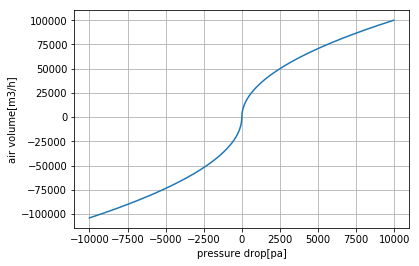

In [21]:
# 収束用関数の連続性の確認(bisectの初期値の検討)

# /検討パラメータ
val_min = -1 * 10**4
val_max = 10**4
# 検討パラメータ/

house_story_number = 2
room_air_temperature = 20
outside_air_temperature = 0
c_value = 2
total_floor_area = 120
ventilation_type = 3
use_chimney = False
alphaA_SA = 0.1
alphaA_EA = 0.1

x = np.zeros(1000)
y = np.zeros(1000)

stp = (val_max - val_min) / 1000
    
for t in range(1000):
    
    x[t] = val_min + stp * t
    
    pressure_difference = x[t]
    
    y[t] = f(pressure_difference, \
             house_story_number, \
             room_air_temperature, \
             outside_air_temperature, \
             c_value, \
             total_floor_area, \
             ventilation_type, \
             use_chimney, \
             alphaA_SA, \
             alphaA_EA)[0]
    
    # print (t, x[t], y[t])
    
    
# plt.figure(figsize=(9,2))
# plt.subplot(1,1,1)
plt.plot(x, y)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("pressure drop[pa]")
plt.ylabel("air volume[m3/h]")

# plt.xlim(3.9,4)
# plt.ylim(-1,1)

plt.legend()
plt.show()




In [22]:
# すきま風マクロ.xlsmの結果と一致するか確認（繰り返し計算あり）

val_min = -1 * 10**3
val_max = 10**3
maximum_iterations = 10**4
house_story_number = 2 # 階
room_air_temperature = 20 # ℃
outside_air_temperature = 0 # ℃
c_value = 2  # cm^2/m^2
total_floor_area = 120 # m^2
ventilation_type = 3
use_chimney = False
alphaA_SA = 0.1 # m^2
alphaA_EA = 0.1 # m^2

get_natural_ventilation_volume_by_scipy(val_min, \
                                        val_max, \
                                        maximum_iterations, \
                                        house_story_number, \
                                        room_air_temperature, \
                                        outside_air_temperature, \
                                        c_value, \
                                        total_floor_area, \
                                        ventilation_type, \
                                        use_chimney, \
                                        alphaA_SA, \
                                        alphaA_EA)


495.97006905313913

# テスト

## ハイブリッド換気

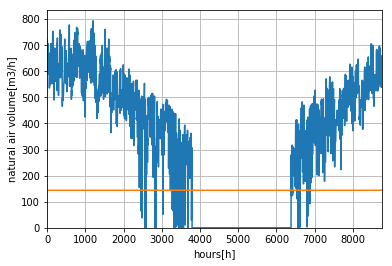

In [23]:
# 温度差利用ハイブリッド換気の自然換気量の確認

area_number = 1 # 地域区分

outside_air_temperature_d_t = import_outside_air_temperature_d_t(area_number)
HeatingSeason_d = import_heating_season_d(area_number)

val_min = -1 * 10**3
val_max = 10**3
maximum_iterations = 10**4
house_story_number = 2 # 階
room_air_temperature = 20 # ℃
c_value = 2 # cm^2/m^2
total_floor_area = 120 # m^2 
ventilation_type = 3
use_chimney = False
alphaA_SA = 0.1 # m^2
alphaA_EA = 0.1 # m^2


x = np.arange(8760)
y =get_natural_ventilation_volume_d_t(outside_air_temperature_d_t, \
                                       HeatingSeason_d,  \
                                       val_min, \
                                       val_max, \
                                       maximum_iterations, \
                                       house_story_number, \
                                       room_air_temperature, \
                                       c_value, \
                                       total_floor_area, \
                                       ventilation_type, \
                                       use_chimney, \
                                       alphaA_SA, \
                                       alphaA_EA)

# 機械換気風量
v = np.ones(8760)
v = v * total_floor_area * 2.4 * 0.5

plt.plot(x, y)
plt.plot(x, v)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("hours[h]")
plt.ylabel("natural air volume[m3/h]")

plt.xlim(0, 8760)
plt.ylim(0,)

plt.legend()
plt.show()


## 全体テスト

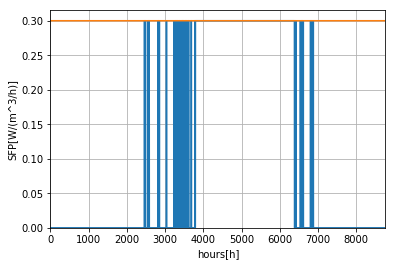

In [24]:
# 全体での動作確認

ventilation_control_mode = "温度差利用型ハイブリッド運転" # "制御しない" "片側運転" "バイパス運転" "温度差利用型ハイブリッド運転"
f_SFP = 0.3
f_SFP_bypass = 0.2

area_number = 1 # 地域区分

outside_air_temperature_d_t = import_outside_air_temperature_d_t(area_number)
HeatingSeason_d = import_heating_season_d(area_number)

total_floor_area = 120 # m^2 

val_min = -1 * 10**3
val_max = 10**3
maximum_iterations = 10**4
house_story_number = 2 # 階
room_air_temperature = 20 # ℃
c_value = 2 # cm^2/m^2
total_floor_area = 120 # m^2 
ventilation_type = 3
use_chimney = False
alphaA_vnt_sum = 0.2 # m^2 

x = np.arange(8760)
y = get_SFP_d_t(ventilation_control_mode, \
                f_SFP, \
                f_SFP_bypass, \
                HeatingSeason_d, \
                outside_air_temperature_d_t, \
                area_number, \
                total_floor_area, \
                val_min, \
                val_max, \
                maximum_iterations, \
                house_story_number, \
                room_air_temperature, \
                c_value, \
                ventilation_type, \
                use_chimney, \
                alphaA_vnt_sum)

# 通常のSFP
v = np.ones(8760)
v = v * f_SFP

plt.plot(x, y)
plt.plot(x, v)

plt.grid(True)

# plt.title("hours/kWh")
plt.xlabel("hours[h]")
plt.ylabel("SFP[W/(m^3/h)]")

plt.xlim(0, 8760)
plt.ylim(0,)

plt.legend()
plt.show()
